In [1]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)
library(stringr)
library(lubridate)
library(purrr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard




Read both csv files, and convert the timestamp to UTC format

In [2]:
df_log1 <- read.csv(file = 'energy_troll-1_11-06-22-25.csv', sep = ',', stringsAsFactors = FALSE, header = FALSE)
df_log2 <- read.csv(file = 'energy_troll-2_11-06-22-25.csv', sep = ',', stringsAsFactors = FALSE, header = FALSE)
df_log3 <- read.csv(file = 'energy_troll-4_11-06-22-25.csv', sep = ',', stringsAsFactors = FALSE, header = FALSE)
df_log <- bind_rows(df_log1, df_log2, df_log3)

names(df_log) <- c("timestamp", "device_id", "metric_id", "value", "labels")
df_log$timestamp <- as.POSIXct(df_log$timestamp, format="%Y-%m-%dT%H:%M:%S", tz="UTC")

summary(df_log)
#head(df_log)
#tail(df_log)

   timestamp                    device_id          metric_id        
 Min.   :2023-06-11 22:25:00   Length:108003      Length:108003     
 1st Qu.:2023-06-12 00:55:00   Class :character   Class :character  
 Median :2023-06-12 03:25:00   Mode  :character   Mode  :character  
 Mean   :2023-06-12 03:25:00                                        
 3rd Qu.:2023-06-12 05:55:00                                        
 Max.   :2023-06-12 08:25:00                                        
     value          labels         
 Min.   :161.0   Length:108003     
 1st Qu.:196.7   Class :character  
 Median :205.3   Mode  :character  
 Mean   :209.8                     
 3rd Qu.:212.1                     
 Max.   :391.5                     

Saving 6.67 x 6.67 in image


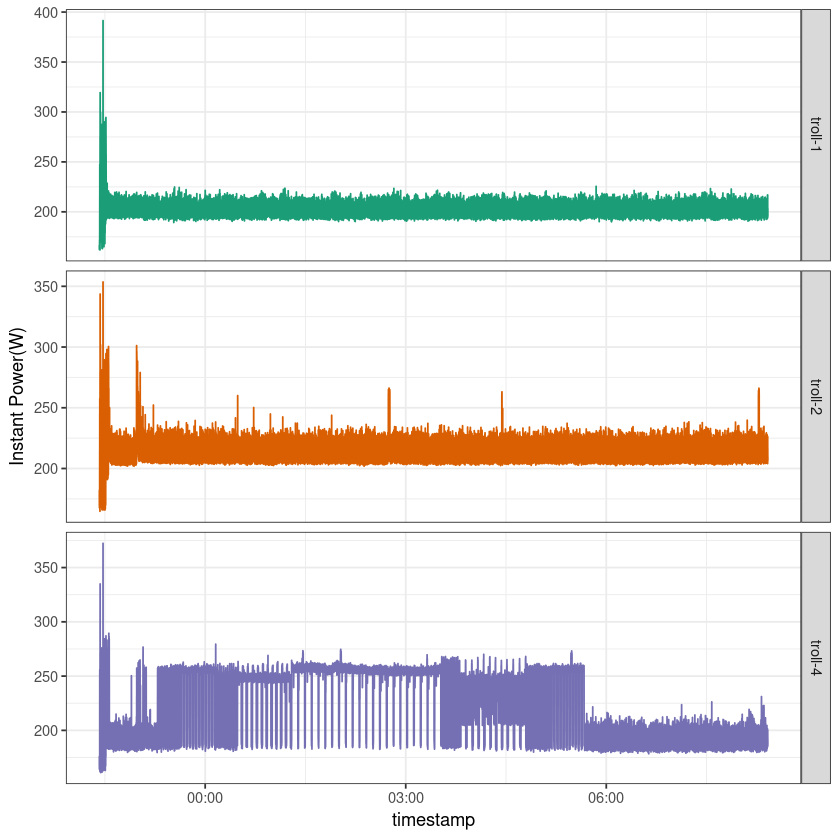

In [3]:
ggplot(data = df_log, aes(x = timestamp, y = value, color = device_id,)) + #, color = node)) +
    geom_line() +
    #geom_point(size = 0.5, position = position_dodge(width = 0.7)) +
    facet_grid(device_id ~ ., scale="free_y") +
    labs(x = "timestamp", y = "Instant Power(W)") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="none") 
    #guides(colour=guide_legend(nrow=4,byrow=TRUE, title.position = "top"))
    ggsave('full_line_plot.png')

In [4]:
# Creating a list of indexes to be binded to the dataframe

timestamp_indexes <- data.frame(time_index = seq(1:dim(df_log)[1]))
df_log_index <- df_log %>% bind_cols(timestamp_indexes)
summary(df_log_index)

   timestamp                    device_id          metric_id        
 Min.   :2023-06-11 22:25:00   Length:108003      Length:108003     
 1st Qu.:2023-06-12 00:55:00   Class :character   Class :character  
 Median :2023-06-12 03:25:00   Mode  :character   Mode  :character  
 Mean   :2023-06-12 03:25:00                                        
 3rd Qu.:2023-06-12 05:55:00                                        
 Max.   :2023-06-12 08:25:00                                        
     value          labels            time_index    
 Min.   :161.0   Length:108003      Min.   :     1  
 1st Qu.:196.7   Class :character   1st Qu.: 27002  
 Median :205.3   Mode  :character   Median : 54002  
 Mean   :209.8                      Mean   : 54002  
 3rd Qu.:212.1                      3rd Qu.: 81002  
 Max.   :391.5                      Max.   :108003  

In [5]:
# Compute time interval (replace with your actual time interval if not 1 second)
start_timestamp = first(df_log_index["time_index"])
end_timestamp = last(df_log_index["time_index"])
#time_interval = end_timestamp - start_timestamp
time_interval = 1 # the interval between the measurements

# Calculate the energy consumption using the trapezoidal rule
total_energy <- df_log_index %>%
    group_by(device_id) %>%
    mutate(x1 = time_index, x2 = lead(time_index),
         y1 = value, y2 = lead(value)) %>%
    mutate(area = (y1 + y2) * (x2 - x1) / 2 * time_interval) %>%
    summarise(total_energy = sum(area, na.rm = TRUE),
              total_energy_in_kwh = sum(area, na.rm = TRUE)/3600000)

    # Print the total energy consumption
print(total_energy)

# To decide if I should use the duration per second or hour

# A tibble: 3 × 3
  device_id total_energy total_energy_in_kwh
  <chr>            <dbl>               <dbl>
1 troll-1       7194344.                2.00
2 troll-2       7584505.                2.11
3 troll-4       7880285.                2.19


Read the activation logs and update the timestamp to the correct timezone

## Now I need to read the activation_energy logs from Openwhisk
### There we have mostly start_ and finish_time. To merge with the energy dataframe above, I need to create the timestamps between the start_ and end_ timestamps.

In [6]:
df_activations <- read.csv(file = 'activation_energy_11-06-08-20.csv', sep = ',', stringsAsFactors = FALSE)
head(df_activations)
df_activations %>% filter(function_name== "matmul_1")

df_activations$timestamp <- as.integer(df_activations$timestamp)
df_activations$timestamp <- as_datetime(df_activations$timestamp) + hours(2)
df_activations$timestamp <- as.POSIXct(df_activations$timestamp, format="%Y-%m-%dT%H:%M:%S", tz="UTC")

head(df_activations)
tail(df_activations)

object_uid                       object_name function_name duration
1 2bca906010ff44698a906010ffe46962 pyaes_20    pyaes_20      99.76217
2 2bca906010ff44698a906010ffe46962 pyaes_20    pyaes_20            NA
3 2bca906010ff44698a906010ffe46962 pyaes_20    pyaes_20            NA
4 2bca906010ff44698a906010ffe46962 pyaes_20    pyaes_20            NA
5 eb2928c52b61496ea928c52b61296e23 pyaes_19    pyaes_19      98.58529
6 eb2928c52b61496ea928c52b61296e23 pyaes_19    pyaes_19            NA
  timestamp  reason             metadata_value metadata_description node
1         NA function_execution   NA                                NA  
2         NA                    4000           metadata_input       NA  
3 1686541204 finishing_time       NA                                NA  
4 1686541105 starting_time        NA                                NA  
5         NA function_execution   NA                                NA  
6         NA                    4000           metadata_input       NA  
  message
1 NA     
2 NA     
3 NA     
4 NA     
5 NA     
6 NA

object_uid                       object_name function_name duration
1 24dbf2351aab42389bf2351aabe23869 matmul_1    matmul_1      10      
2 24dbf2351aab42389bf2351aabe23869 matmul_1    matmul_1      NA      
3 24dbf2351aab42389bf2351aabe23869 matmul_1    matmul_1      NA      
4 24dbf2351aab42389bf2351aabe23869 matmul_1    matmul_1      NA      
  timestamp  reason             metadata_value metadata_description node
1         NA function_execution   NA                                NA  
2         NA                    5000           metadata_input       NA  
3 1686533459 finishing_time       NA                                NA  
4 1686529492 starting_time        NA                                NA  
  message
1 NA     
2 NA     
3 NA     
4 NA

object_uid                       object_name function_name duration
1 2bca906010ff44698a906010ffe46962 pyaes_20    pyaes_20      99.76217
2 2bca906010ff44698a906010ffe46962 pyaes_20    pyaes_20            NA
3 2bca906010ff44698a906010ffe46962 pyaes_20    pyaes_20            NA
4 2bca906010ff44698a906010ffe46962 pyaes_20    pyaes_20            NA
5 eb2928c52b61496ea928c52b61296e23 pyaes_19    pyaes_19      98.58529
6 eb2928c52b61496ea928c52b61296e23 pyaes_19    pyaes_19            NA
  timestamp           reason             metadata_value metadata_description
1 <NA>                function_execution   NA                               
2 <NA>                                   4000           metadata_input      
3 2023-06-12 05:40:04 finishing_time       NA                               
4 2023-06-12 05:38:24 starting_time        NA                               
5 <NA>                function_execution   NA                               
6 <NA>                                   4000           metadata_input      
  node message
1 NA   NA     
2 NA   NA     
3 NA   NA     
4 NA   NA     
5 NA   NA     
6 NA   NA

object_uid                       object_name      function_name    duration
363 7492da284e4c4aa092da284e4c2aa0fc floatoperation_4 floatoperation_4       NA
364 7492da284e4c4aa092da284e4c2aa0fc floatoperation_4 floatoperation_4       NA
365 1616e1792ef64bac96e1792ef6fbacb5 floatoperation_3 floatoperation_3 50.65772
366 1616e1792ef64bac96e1792ef6fbacb5 floatoperation_3 floatoperation_3       NA
367 1616e1792ef64bac96e1792ef6fbacb5 floatoperation_3 floatoperation_3       NA
368 1616e1792ef64bac96e1792ef6fbacb5 floatoperation_3 floatoperation_3       NA
    timestamp           reason             metadata_value metadata_description
363 2023-06-11 23:07:04 finishing_time            NA                          
364 2023-06-11 23:06:13 starting_time             NA                          
365 <NA>                function_execution        NA                          
366 <NA>                                   100000000      metadata_input      
367 2023-06-11 23:05:09 finishing_time            NA                          
368 2023-06-11 23:04:18 starting_time             NA                          
    node message
363 NA   NA     
364 NA   NA     
365 NA   NA     
366 NA   NA     
367 NA   NA     
368 NA   NA

In [7]:
df_activations %>% filter(function_name == "matmul_1")

object_uid                       object_name function_name duration
1 24dbf2351aab42389bf2351aabe23869 matmul_1    matmul_1      10      
2 24dbf2351aab42389bf2351aabe23869 matmul_1    matmul_1      NA      
3 24dbf2351aab42389bf2351aabe23869 matmul_1    matmul_1      NA      
4 24dbf2351aab42389bf2351aabe23869 matmul_1    matmul_1      NA      
  timestamp           reason             metadata_value metadata_description
1 <NA>                function_execution   NA                               
2 <NA>                                   5000           metadata_input      
3 2023-06-12 03:30:59 finishing_time       NA                               
4 2023-06-12 02:24:52 starting_time        NA                               
  node message
1 NA   NA     
2 NA   NA     
3 NA   NA     
4 NA   NA

#'2023-06-12 12:08:19' AM
'2023-06-11 00:08:19'

end last matmul 1686533459158 'June 12, 2023 3:30:59.158 AM'
start last matmul 1686529492367 '12, 2023 2:24:52.367 AM'

end matmul 1686529427373 'June 12, 2023 2:23:47.373 AM'
start matmul 1686525458843 'June 12, 2023 1:17:38.843 AM'

last chameleon 1686525391256 'June 12, 2023 1:16:31.256 AM'

In [8]:
df_activations_selected <- df_activations %>%
    select(
        function_name,
        duration,
        reason,
        timestamp,
        object_uid,
        metadata_value)#,
        #node,
        #metadata_description)

# Spread the metadata_value (function input) to the same object_id functions
# I use MAX because they are all the same, per function

df_activations_selected <- df_activations_selected %>%
    group_by(object_uid) %>%
    mutate(metadata_value = max(metadata_value,na.rm = TRUE)) %>% 
    filter(reason != "") %>%
    ungroup()

# Combine the function name with the function input, and split them to get function_group

df_activations_selected <- df_activations_selected %>%
    group_by(function_name, metadata_value) %>%
    mutate(function_group = strsplit(function_name, "\\_")[[1]][1]) %>%
    mutate(function_metadata = paste(strsplit(function_name, "\\_")[[1]][1],
                    metadata_value,
                    sep="_"))

head(df_activations_selected)
tail(df_activations_selected)

function_name duration reason             timestamp          
1 pyaes_20      99.76217 function_execution <NA>               
2 pyaes_20            NA finishing_time     2023-06-12 05:40:04
3 pyaes_20            NA starting_time      2023-06-12 05:38:24
4 pyaes_19      98.58529 function_execution <NA>               
5 pyaes_19            NA finishing_time     2023-06-12 05:37:20
6 pyaes_19            NA starting_time      2023-06-12 05:35:42
  object_uid                       metadata_value function_group
1 2bca906010ff44698a906010ffe46962 4000           pyaes         
2 2bca906010ff44698a906010ffe46962 4000           pyaes         
3 2bca906010ff44698a906010ffe46962 4000           pyaes         
4 eb2928c52b61496ea928c52b61296e23 4000           pyaes         
5 eb2928c52b61496ea928c52b61296e23 4000           pyaes         
6 eb2928c52b61496ea928c52b61296e23 4000           pyaes         
  function_metadata
1 pyaes_4000       
2 pyaes_4000       
3 pyaes_4000       
4 pyaes_4000       
5 pyaes_4000       
6 pyaes_4000

function_name    duration reason             timestamp          
1 floatoperation_4 51.22868 function_execution <NA>               
2 floatoperation_4       NA finishing_time     2023-06-11 23:07:04
3 floatoperation_4       NA starting_time      2023-06-11 23:06:13
4 floatoperation_3 50.65772 function_execution <NA>               
5 floatoperation_3       NA finishing_time     2023-06-11 23:05:09
6 floatoperation_3       NA starting_time      2023-06-11 23:04:18
  object_uid                       metadata_value function_group
1 7492da284e4c4aa092da284e4c2aa0fc 100000000      floatoperation
2 7492da284e4c4aa092da284e4c2aa0fc 100000000      floatoperation
3 7492da284e4c4aa092da284e4c2aa0fc 100000000      floatoperation
4 1616e1792ef64bac96e1792ef6fbacb5 100000000      floatoperation
5 1616e1792ef64bac96e1792ef6fbacb5 100000000      floatoperation
6 1616e1792ef64bac96e1792ef6fbacb5 100000000      floatoperation
  function_metadata       
1 floatoperation_100000000
2 floatoperation_100000000
3 floatoperation_100000000
4 floatoperation_100000000
5 floatoperation_100000000
6 floatoperation_100000000

In [9]:
df_activations_managed <- df_activations_selected %>%
    select(-duration) %>%
    group_by(object_uid) %>%
    drop_na() %>%
    mutate(finish = first(timestamp),
          start = last(timestamp)) %>%
    select(-reason, -timestamp) %>%
    distinct() %>%
    ungroup()

head(df_activations_managed)

function_name object_uid                       metadata_value function_group
1 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
2 pyaes_19      eb2928c52b61496ea928c52b61296e23 4000           pyaes         
3 pyaes_18      eaac38cdcf1d4235ac38cdcf1d623506 4000           pyaes         
4 pyaes_17      bb6d515aab74457fad515aab74757f4e 4000           pyaes         
5 pyaes_16      8192056b26dc48cd92056b26dcf8cd10 4000           pyaes         
6 pyaes_15      f7b2d15b818946ecb2d15b8189c6ec65 4000           pyaes         
  function_metadata finish              start              
1 pyaes_4000        2023-06-12 05:40:04 2023-06-12 05:38:24
2 pyaes_4000        2023-06-12 05:37:20 2023-06-12 05:35:42
3 pyaes_4000        2023-06-12 05:34:38 2023-06-12 05:33:00
4 pyaes_4000        2023-06-12 05:31:56 2023-06-12 05:30:17
5 pyaes_4000        2023-06-12 05:29:14 2023-06-12 05:27:35
6 pyaes_4000        2023-06-12 05:26:32 2023-06-12 05:24:53

In [10]:
df_activations_generated <- df_activations_managed %>%
    group_by(function_name,object_uid,metadata_value,function_group,function_metadata,start,finish) %>%
    mutate(timestamp = list(seq(start, finish, by = "1 sec"))) %>%
    unnest(timestamp) %>%
    ungroup() %>%
    select(-start, -finish)

head(df_activations_generated)

function_name object_uid                       metadata_value function_group
1 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
2 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
3 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
4 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
5 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
6 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
  function_metadata timestamp          
1 pyaes_4000        2023-06-12 05:38:24
2 pyaes_4000        2023-06-12 05:38:25
3 pyaes_4000        2023-06-12 05:38:26
4 pyaes_4000        2023-06-12 05:38:27
5 pyaes_4000        2023-06-12 05:38:28
6 pyaes_4000        2023-06-12 05:38:29

## Finally, we can merge both dataframes by timestamp

In [11]:
head(df_activations_generated)
tail(df_activations_generated)
head(df_log_index)

function_name object_uid                       metadata_value function_group
1 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
2 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
3 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
4 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
5 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
6 pyaes_20      2bca906010ff44698a906010ffe46962 4000           pyaes         
  function_metadata timestamp          
1 pyaes_4000        2023-06-12 05:38:24
2 pyaes_4000        2023-06-12 05:38:25
3 pyaes_4000        2023-06-12 05:38:26
4 pyaes_4000        2023-06-12 05:38:27
5 pyaes_4000        2023-06-12 05:38:28
6 pyaes_4000        2023-06-12 05:38:29

function_name    object_uid                       metadata_value
1 floatoperation_3 1616e1792ef64bac96e1792ef6fbacb5 100000000     
2 floatoperation_3 1616e1792ef64bac96e1792ef6fbacb5 100000000     
3 floatoperation_3 1616e1792ef64bac96e1792ef6fbacb5 100000000     
4 floatoperation_3 1616e1792ef64bac96e1792ef6fbacb5 100000000     
5 floatoperation_3 1616e1792ef64bac96e1792ef6fbacb5 100000000     
6 floatoperation_3 1616e1792ef64bac96e1792ef6fbacb5 100000000     
  function_group function_metadata        timestamp          
1 floatoperation floatoperation_100000000 2023-06-11 23:05:04
2 floatoperation floatoperation_100000000 2023-06-11 23:05:05
3 floatoperation floatoperation_100000000 2023-06-11 23:05:06
4 floatoperation floatoperation_100000000 2023-06-11 23:05:07
5 floatoperation floatoperation_100000000 2023-06-11 23:05:08
6 floatoperation floatoperation_100000000 2023-06-11 23:05:09

timestamp           device_id metric_id            value  
1 2023-06-11 22:25:00 troll-1   wattmetre_power_watt 164.912
2 2023-06-11 22:25:01 troll-1   wattmetre_power_watt 166.190
3 2023-06-11 22:25:02 troll-1   wattmetre_power_watt 162.412
4 2023-06-11 22:25:03 troll-1   wattmetre_power_watt 165.526
5 2023-06-11 22:25:04 troll-1   wattmetre_power_watt 162.908
6 2023-06-11 22:25:05 troll-1   wattmetre_power_watt 165.448
  labels                                time_index
1 {"_device_orig":["wattmetre1-port8"]} 1         
2 {"_device_orig":["wattmetre1-port8"]} 2         
3 {"_device_orig":["wattmetre1-port8"]} 3         
4 {"_device_orig":["wattmetre1-port8"]} 4         
5 {"_device_orig":["wattmetre1-port8"]} 5         
6 {"_device_orig":["wattmetre1-port8"]} 6

Join both datasets

In [12]:
df_joined <- full_join(
       df_log_index, #%>% filter(device_id == 'troll-4'),
       df_activations_generated,
       by="timestamp") #%>%

head(df_joined)
tail(df_joined)

timestamp           device_id metric_id            value  
1 2023-06-11 22:25:00 troll-1   wattmetre_power_watt 164.912
2 2023-06-11 22:25:01 troll-1   wattmetre_power_watt 166.190
3 2023-06-11 22:25:02 troll-1   wattmetre_power_watt 162.412
4 2023-06-11 22:25:03 troll-1   wattmetre_power_watt 165.526
5 2023-06-11 22:25:04 troll-1   wattmetre_power_watt 162.908
6 2023-06-11 22:25:05 troll-1   wattmetre_power_watt 165.448
  labels                                time_index function_name object_uid
1 {"_device_orig":["wattmetre1-port8"]} 1          NA            NA        
2 {"_device_orig":["wattmetre1-port8"]} 2          NA            NA        
3 {"_device_orig":["wattmetre1-port8"]} 3          NA            NA        
4 {"_device_orig":["wattmetre1-port8"]} 4          NA            NA        
5 {"_device_orig":["wattmetre1-port8"]} 5          NA            NA        
6 {"_device_orig":["wattmetre1-port8"]} 6          NA            NA        
  metadata_value function_group function_metadata
1 NA             NA             NA               
2 NA             NA             NA               
3 NA             NA             NA               
4 NA             NA             NA               
5 NA             NA             NA               
6 NA             NA             NA

timestamp           device_id metric_id            value   
107998 2023-06-12 08:24:55 troll-4   wattmetre_power_watt 190.1900
107999 2023-06-12 08:24:56 troll-4   wattmetre_power_watt 185.7420
108000 2023-06-12 08:24:57 troll-4   wattmetre_power_watt 193.0520
108001 2023-06-12 08:24:58 troll-4   wattmetre_power_watt 186.1275
108002 2023-06-12 08:24:59 troll-4   wattmetre_power_watt 190.6673
108003 2023-06-12 08:25:00 troll-4   wattmetre_power_watt 187.2400
       labels                                 time_index function_name
107998 {"_device_orig":["wattmetre1-port11"]} 107998     NA           
107999 {"_device_orig":["wattmetre1-port11"]} 107999     NA           
108000 {"_device_orig":["wattmetre1-port11"]} 108000     NA           
108001 {"_device_orig":["wattmetre1-port11"]} 108001     NA           
108002 {"_device_orig":["wattmetre1-port11"]} 108002     NA           
108003 {"_device_orig":["wattmetre1-port11"]} 108003     NA           
       object_uid metadata_value function_group function_metadata
107998 NA         NA             NA             NA               
107999 NA         NA             NA             NA               
108000 NA         NA             NA             NA               
108001 NA         NA             NA             NA               
108002 NA         NA             NA             NA               
108003 NA         NA             NA             NA

In [13]:
# Attribute openwhisk and platfoms as function and group name for the df_log datasets

df_all <- df_joined %>%
    mutate(function_name = ifelse(is.na(function_name), 'openwhisk', function_name)) %>%
    mutate(function_group = ifelse(is.na(function_group), 'platform', function_group)) %>%
    mutate(function_metadata = ifelse(is.na(function_metadata), 'platform', function_metadata))

head(df_all)
tail(df_all)

timestamp           device_id metric_id            value  
1 2023-06-11 22:25:00 troll-1   wattmetre_power_watt 164.912
2 2023-06-11 22:25:01 troll-1   wattmetre_power_watt 166.190
3 2023-06-11 22:25:02 troll-1   wattmetre_power_watt 162.412
4 2023-06-11 22:25:03 troll-1   wattmetre_power_watt 165.526
5 2023-06-11 22:25:04 troll-1   wattmetre_power_watt 162.908
6 2023-06-11 22:25:05 troll-1   wattmetre_power_watt 165.448
  labels                                time_index function_name object_uid
1 {"_device_orig":["wattmetre1-port8"]} 1          openwhisk     NA        
2 {"_device_orig":["wattmetre1-port8"]} 2          openwhisk     NA        
3 {"_device_orig":["wattmetre1-port8"]} 3          openwhisk     NA        
4 {"_device_orig":["wattmetre1-port8"]} 4          openwhisk     NA        
5 {"_device_orig":["wattmetre1-port8"]} 5          openwhisk     NA        
6 {"_device_orig":["wattmetre1-port8"]} 6          openwhisk     NA        
  metadata_value function_group function_metadata
1 NA             platform       platform         
2 NA             platform       platform         
3 NA             platform       platform         
4 NA             platform       platform         
5 NA             platform       platform         
6 NA             platform       platform

timestamp           device_id metric_id            value   
107998 2023-06-12 08:24:55 troll-4   wattmetre_power_watt 190.1900
107999 2023-06-12 08:24:56 troll-4   wattmetre_power_watt 185.7420
108000 2023-06-12 08:24:57 troll-4   wattmetre_power_watt 193.0520
108001 2023-06-12 08:24:58 troll-4   wattmetre_power_watt 186.1275
108002 2023-06-12 08:24:59 troll-4   wattmetre_power_watt 190.6673
108003 2023-06-12 08:25:00 troll-4   wattmetre_power_watt 187.2400
       labels                                 time_index function_name
107998 {"_device_orig":["wattmetre1-port11"]} 107998     openwhisk    
107999 {"_device_orig":["wattmetre1-port11"]} 107999     openwhisk    
108000 {"_device_orig":["wattmetre1-port11"]} 108000     openwhisk    
108001 {"_device_orig":["wattmetre1-port11"]} 108001     openwhisk    
108002 {"_device_orig":["wattmetre1-port11"]} 108002     openwhisk    
108003 {"_device_orig":["wattmetre1-port11"]} 108003     openwhisk    
       object_uid metadata_value function_group function_metadata
107998 NA         NA             platform       platform         
107999 NA         NA             platform       platform         
108000 NA         NA             platform       platform         
108001 NA         NA             platform       platform         
108002 NA         NA             platform       platform         
108003 NA         NA             platform       platform

Saving 6.67 x 6.67 in image


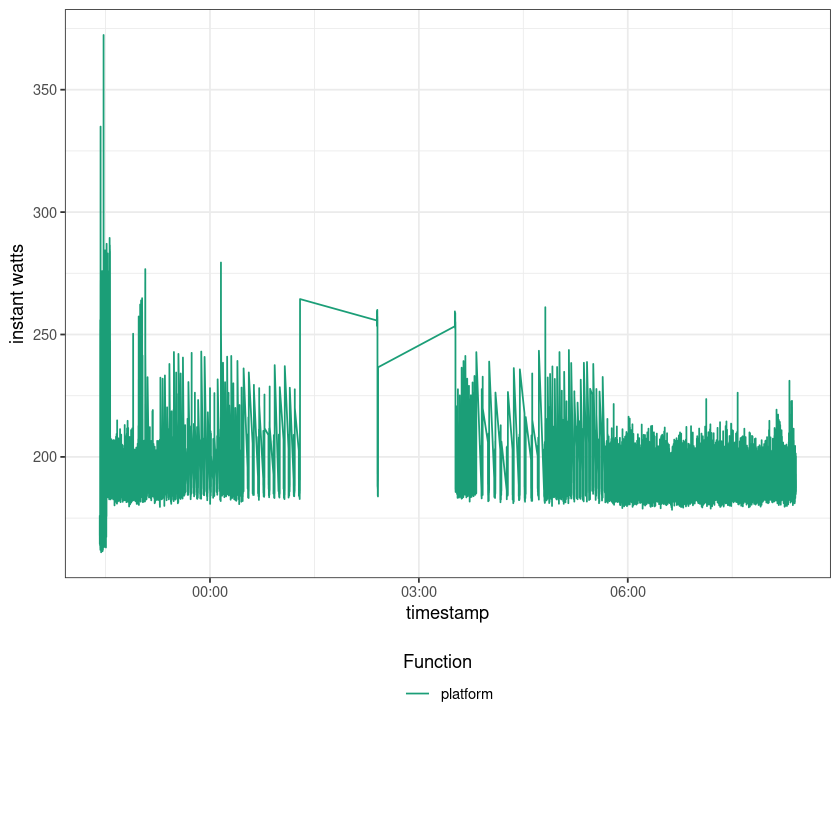

In [14]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4' & function_group == 'platform'), 
              aes(x = timestamp, y = value, color = function_metadata)) + #, color = node)) +) +
    #geom_line(data=df_all %>% filter(device_id == 'troll-4'), aes(x = timestamp, y = value, color = function_name)) + #, color = node)) +
    #geom_vline(data=df_all %>% filter(function_name != 'openwhisk'), 
    #           aes(xintercept = timestamp, color = function_name)) + #, color = node)) +
    #facet_grid(function_group ~ ., scale="free_y") +
    labs(x = "timestamp", y = "instant watts", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=4,byrow=TRUE, title.position = "top"))
    ggsave('energy.png')

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 20416 rows containing missing values (`geom_line()`).”
Saving 6.67 x 6.67 in image
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 20416 rows containing missing values (`geom_line()`).”


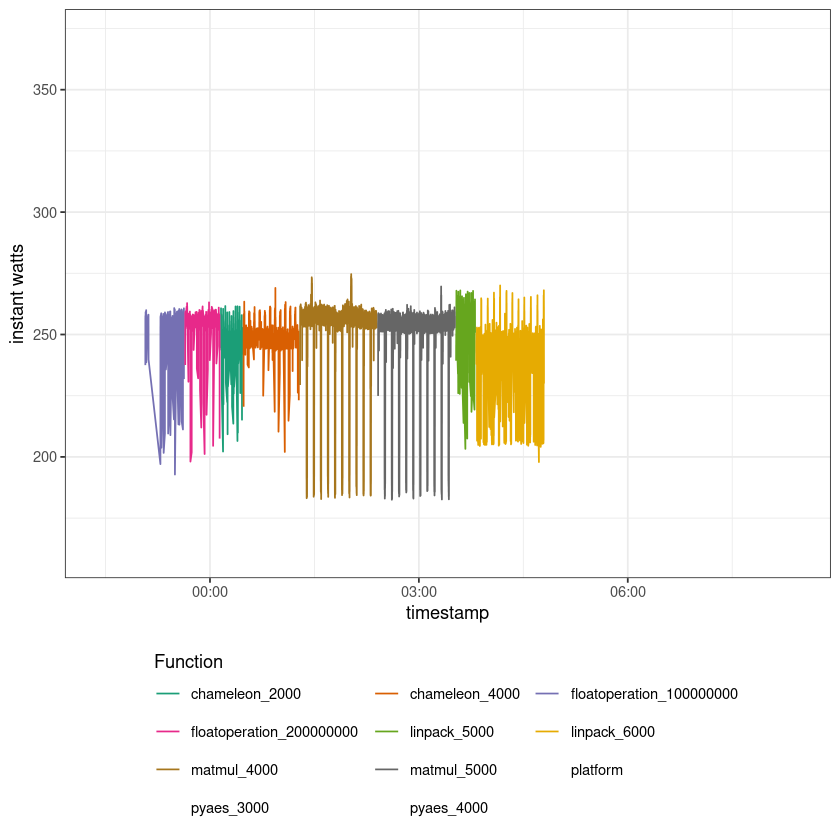

In [15]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4'), #function_group != 'platform'), 
              aes(x = timestamp, y = value, color = function_metadata)) + #, color = node)) +) +
    #geom_line(data=df_all %>% filter(device_id == 'troll-4'), aes(x = timestamp, y = value, color = function_name)) + #, color = node)) +
    #geom_vline(data=df_all %>% filter(function_name != 'openwhisk'), 
    #           aes(xintercept = timestamp, color = function_name)) + #, color = node)) +
    #facet_grid(function_group ~ ., scale="free_y") +
    labs(x = "timestamp", y = "instant watts", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=4,byrow=TRUE, title.position = "top"))
    ggsave('energy.png')

Saving 6.67 x 6.67 in image


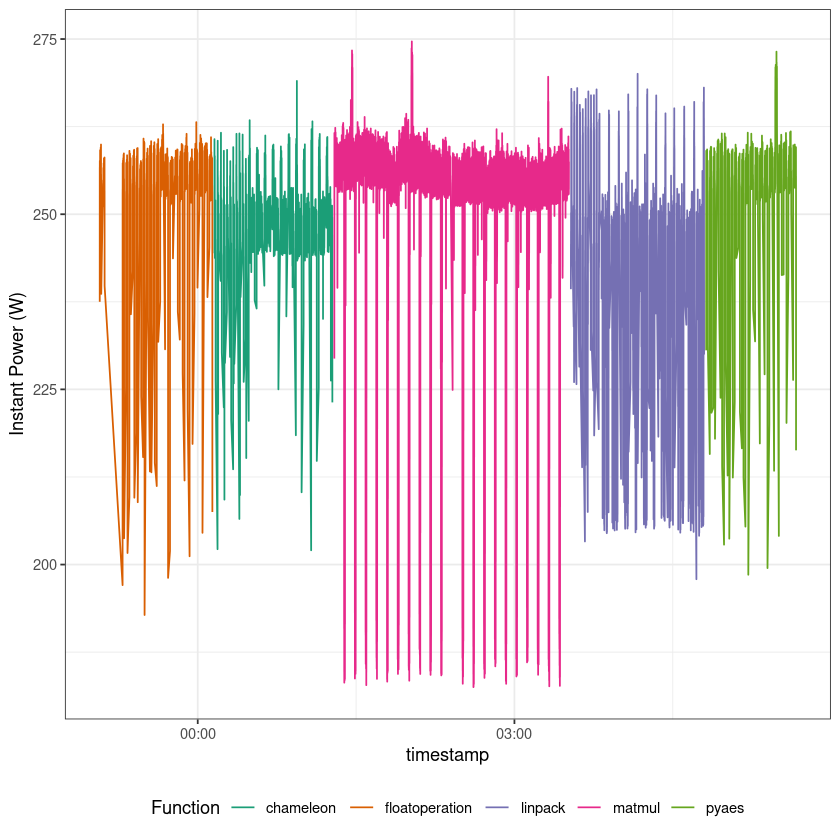

In [16]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4', function_group != 'platform'), 
              aes(x = timestamp, y = value, color = function_group)) + #, color = node)) +) +
    #geom_line(data=df_all %>% filter(device_id == 'troll-4'), aes(x = timestamp, y = value, color = function_name)) + #, color = node)) +
    #geom_vline(data=df_all %>% filter(function_name != 'openwhisk'), 
    #           aes(xintercept = timestamp, color = function_name)) + #, color = node)) +
    #facet_grid(function_group ~ ., scale="free_y") +
    labs(x = "timestamp", y = "Instant Power (W)", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=1,byrow=TRUE, title.position = "left"))
    ggsave('energy-per-group.png')

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 1727 rows containing missing values (`geom_line()`).”
Saving 6.67 x 6.67 in image
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 1727 rows containing missing values (`geom_line()`).”


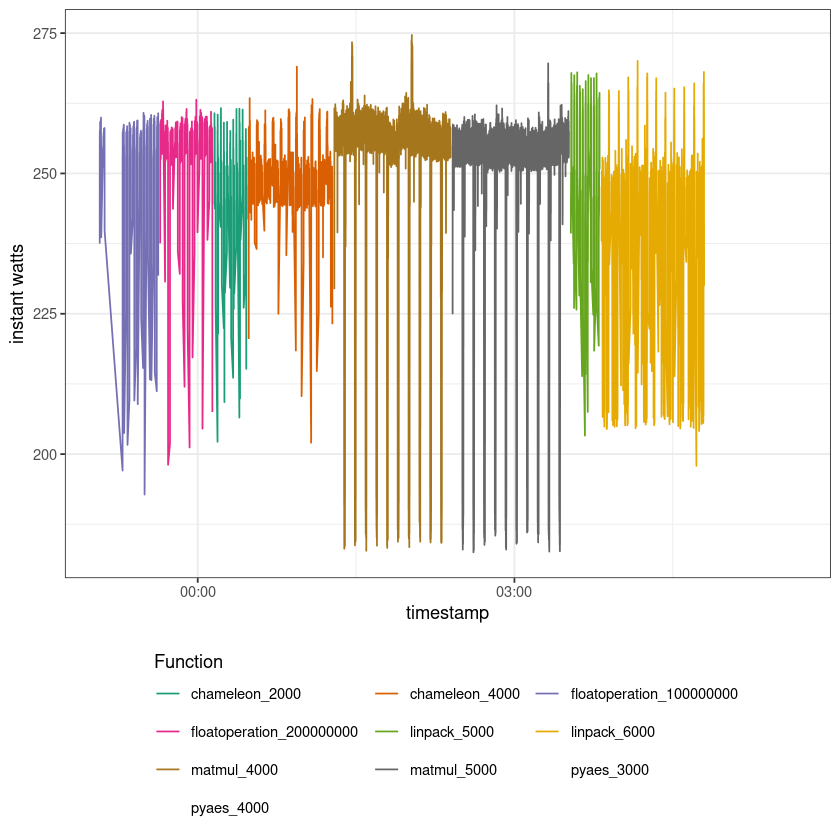

In [17]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4', function_group != 'platform'), 
              aes(x = timestamp, y = value, color = function_metadata)) + #, color = node)) +) +
    #geom_line(data=df_all %>% filter(device_id == 'troll-4'), aes(x = timestamp, y = value, color = function_name)) + #, color = node)) +
    #geom_vline(data=df_all %>% filter(function_name != 'openwhisk'), 
    #           aes(xintercept = timestamp, color = function_name)) + #, color = node)) +
    #facet_grid(function_group ~ ., scale="free_y") +
    labs(x = "timestamp", y = "instant watts", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=4,byrow=TRUE, title.position = "top"))
    ggsave('energy.png')

In [18]:
# Compute time interval (replace with your actual time interval if not 1 second)
start_timestamp = first(df_all["time_index"])
end_timestamp = last(df_all["time_index"])
#time_interval = end_timestamp - start_timestamp
time_interval = 1 #1s

# Calculate the energy consumption using the trapezoidal rule
total_energy <- df_all %>% filter(device_id == 'troll-4', function_metadata != 'platform') %>%
    group_by(function_metadata) %>%
    mutate(x1 = time_index, x2 = lead(time_index),
         y1 = value, y2 = lead(value)) %>%
    mutate(area = (y1 + y2) * (x2 - x1) / 2 * time_interval,
           duration = x2 - x1) %>%
    summarise(total_energy = sum(area, na.rm = TRUE),
              total_duration = sum(duration, na.rm = TRUE))

    # Print the total energy consumption
print(total_energy)

# A tibble: 10 × 3
   function_metadata        total_energy total_duration
   <chr>                           <dbl>          <int>
 1 chameleon_2000                261398.           1103
 2 chameleon_4000                700408.           2852
 3 floatoperation_100000000      461715.           1995
 4 floatoperation_200000000      436689.           1779
 5 linpack_5000                  232608.            979
 6 linpack_6000                  830590.           3497
 7 matmul_4000                   992710.           3969
 8 matmul_5000                   984286.           3967
 9 pyaes_3000                    304333.           1273
10 pyaes_4000                    425529.           1727


In [19]:
total_energy_per_execution <- total_energy %>% 
    mutate(energy_per_call = total_energy / 11,
           #energy_per_call_in_kwh = energy_per_call / 3600000,
           energy_per_call_in_kws = energy_per_call / 1000 , # * 0.001
           duration_per_call = total_duration / 11)

total_energy_per_execution


function_metadata        total_energy total_duration energy_per_call
1  chameleon_2000           261397.7     1103           23763.43       
2  chameleon_4000           700408.4     2852           63673.49       
3  floatoperation_100000000 461715.4     1995           41974.13       
4  floatoperation_200000000 436689.1     1779           39699.01       
5  linpack_5000             232607.7      979           21146.15       
6  linpack_6000             830590.0     3497           75508.18       
7  matmul_4000              992710.1     3969           90246.38       
8  matmul_5000              984286.2     3967           89480.56       
9  pyaes_3000               304333.1     1273           27666.65       
10 pyaes_4000               425529.2     1727           38684.47       
   energy_per_call_in_kws duration_per_call
1  23.76343               100.2727         
2  63.67349               259.2727         
3  41.97413               181.3636         
4  39.69901               161.7273         
5  21.14615                89.0000         
6  75.50818               317.9091         
7  90.24638               360.8182         
8  89.48056               360.6364         
9  27.66665               115.7273         
10 38.68447               157.0000

In [20]:
df_all %>% filter(device_id == 'troll-4' & function_metadata == 'chameleon')

timestamp device_id metric_id value labels time_index function_name
     object_uid metadata_value function_group function_metadata

Saving 6.67 x 6.67 in image


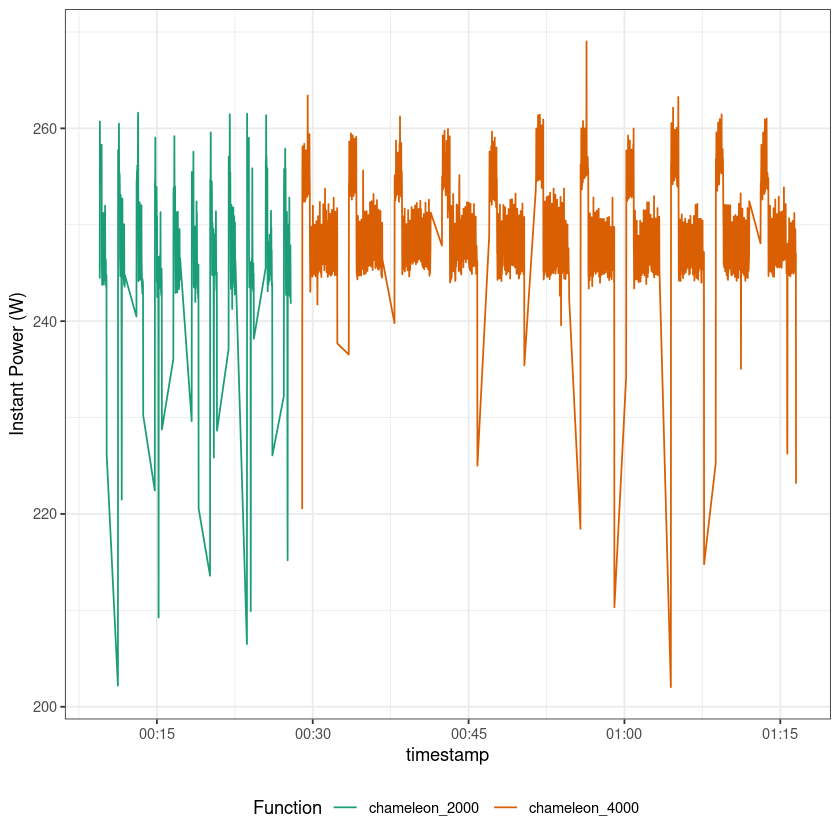

In [21]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4' & function_group == 'chameleon'), 
              aes(x = timestamp, y = value, color = function_metadata)) +
    labs(x = "timestamp", y = "Instant Power (W)", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=1,byrow=TRUE, title.position = "left"))
    ggsave('chameleon.png')

Saving 6.67 x 6.67 in image


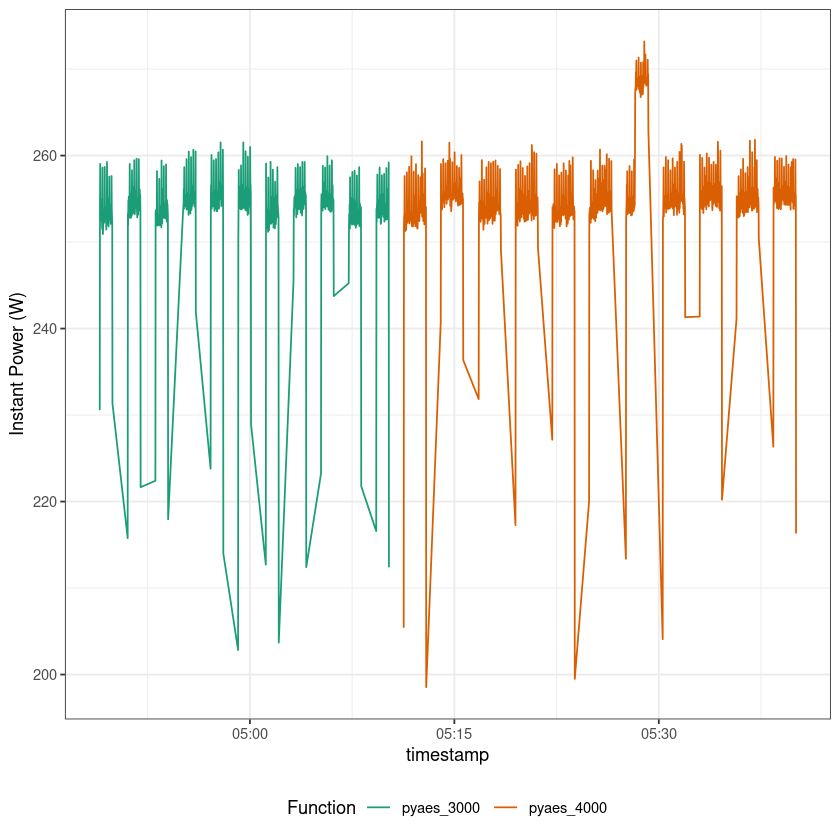

In [22]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4' & function_group == 'pyaes'), 
              aes(x = timestamp, y = value, color = function_metadata)) +
    labs(x = "timestamp", y = "Instant Power (W)", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=1,byrow=TRUE, title.position = "left"))
    ggsave('payes.png')

Saving 6.67 x 6.67 in image


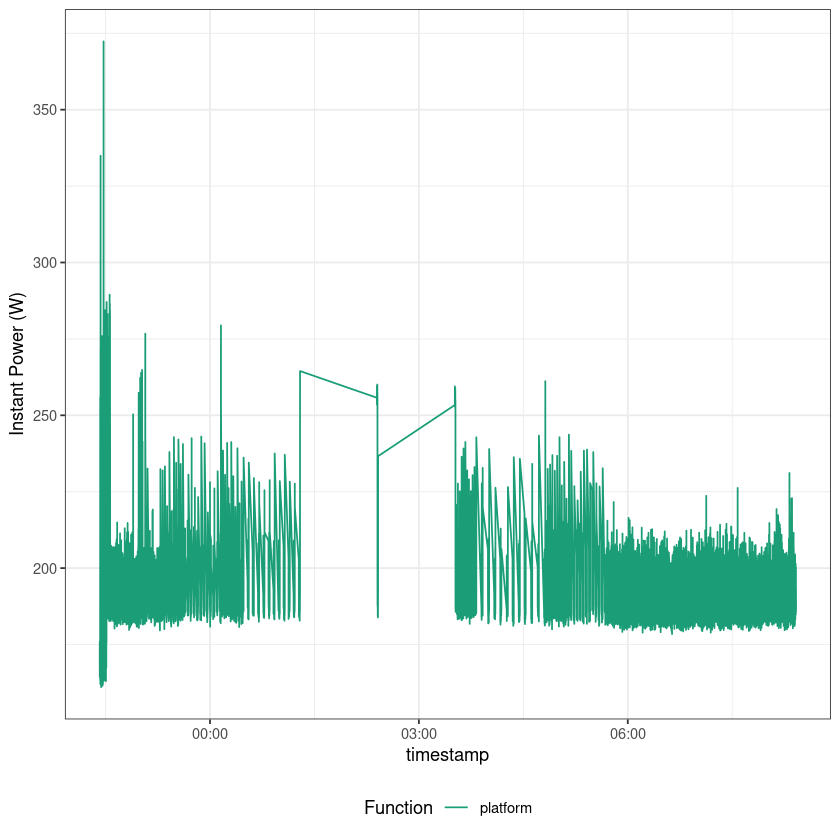

In [23]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4' & function_group == 'platform'), 
              aes(x = timestamp, y = value, color = function_metadata)) +
    labs(x = "timestamp", y = "Instant Power (W)", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=1,byrow=TRUE, title.position = "left"))
    ggsave('payes.png')

Saving 6.67 x 6.67 in image


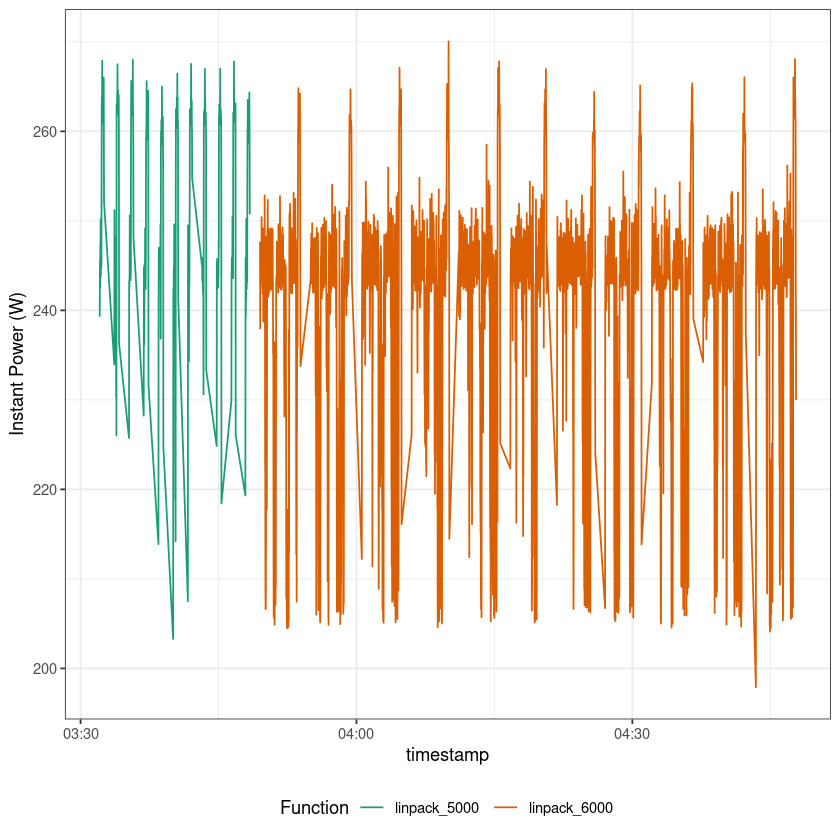

In [24]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4' & function_group == 'linpack'), 
              aes(x = timestamp, y = value, color = function_metadata)) +
    labs(x = "timestamp", y = "Instant Power (W)", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=1,byrow=TRUE, title.position = "left"))
    ggsave('linpack.png')

Saving 6.67 x 6.67 in image


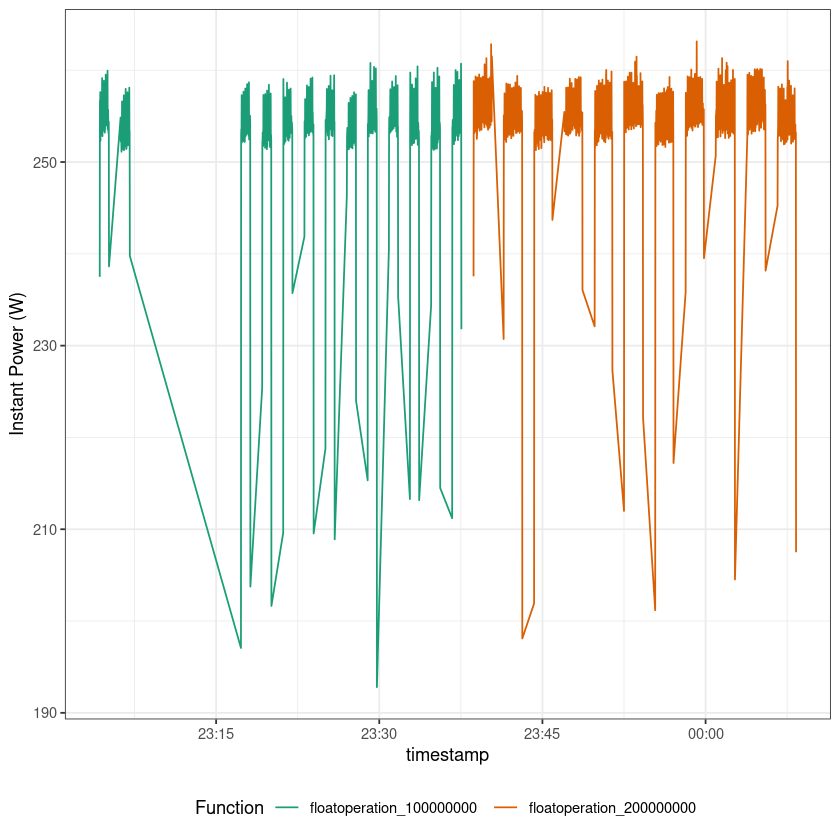

In [25]:
ggplot() +
    geom_line(data=df_all %>% filter(device_id == 'troll-4' & function_group == 'floatoperation'), 
              aes(x = timestamp, y = value, color = function_metadata)) +
    labs(x = "timestamp", y = "Instant Power (W)", color = "Function") +
    scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=1,byrow=TRUE, title.position = "left"))
    ggsave('floatoperation.png')

In [26]:
ggplot() +
    geom_line(data=df_log %>% filter(device_id == 'troll-4'), aes(x = timestamp, y = value)) + #, color = node)) +) +
    geom_point(data=df_all %>% filter(function_name != 'openwhisk'), 
               aes(x = timestamp, y = value, color = function_name, shape=reason)) + #, color = node)) +
    #geom_vline(data=df_all %>% filter(device_id == 'troll-4'), aes(xintercept = timestamp, color = function_name)) + #, color = node)) +
    #facet_grid(device_id ~ ., scale="free_y") +
    labs(x = "timestamp", y = "instant watts", color = "Function") +
    #scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=4,byrow=TRUE, title.position = "top"))
    ggsave('energy2.png')

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 2nd layer.
Caused by error:
! object 'reason' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler

ERROR: [1m[33mError[39m in `geom_point()`:[22m
[1m[22m[33m![39m Problem while computing aesthetics.
[36mℹ[39m Error occurred in the 2nd layer.
[1mCaused by error:[22m
[33m![39m object 'reason' not found


In [ ]:
ggplot() +
    geom_line(data=df_log %>% filter(device_id == 'troll-4'), aes(x = timestamp, y = value)) + #, color = node)) +) +
    geom_point(data=df_all %>% filter(device_id == 'troll-4', reason == "finishing_time"), 
               aes(x = timestamp, y = value, color = function_name, size = 1)) + #, color = node)) +
    facet_grid(device_id ~ ., scale="free_y") +
    labs(x = "timestamp", y = "instant watts", color = "Function") +
    #scale_color_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=4,byrow=TRUE, title.position = "top"))
    ggsave('energy_f.png')

# Getting the duration, and energy consumption

In [ ]:
head(df_all %>% filter(function_name != 'openwhisk'))
tail(df_all %>% filter(function_name != 'openwhisk'))

In [ ]:
df_duration_mutate <- df_all %>%
    filter(function_name != 'openwhisk') %>%
    group_by(function_metadata) %>%
    summarise(duration = max(duration, na.rm = TRUE) / 3600, # To convert seconds in hours
              sum_watt = sum(value, na.rm = TRUE)) %>% 
    distinct() %>%
    ungroup()

head(df_duration_mutate)
tail(df_duration_mutate)

df_duration <- df_duration_mutate %>%
    group_by(function_metadata) %>%
    mutate(energy_consumed = sum_watt * (duration / 1000)) # To have Joules = kWh

head(df_duration)
tail(df_duration)

#head(df_duration)
#tail(df_duration)

In [ ]:
df_duration %>% filter(function_metadata == 'chameleon_1000')

In [ ]:
ggplot() +
    geom_bar(data=df_duration,stat="identity", 
              aes(x = energy_consumed , y = function_metadata)) +
    labs(x = "energy consumed (Avg Power (W) * (time (s) / 1000) )", y = "functions per input", color = "Function") +
    scale_fill_brewer(palette = "Dark2") +
    theme_bw() +
    theme(legend.position="bottom")  + 
    guides(colour=guide_legend(nrow=3,byrow=TRUE, title.position = "top"))
    ggsave('energy_bar.png')

In [ ]:
df_duration_mutate <- df_all %>%
    filter(function_name != 'openwhisk') %>%
    group_by(function_name) %>%
    mutate(duration = max(duration, na.rm = TRUE) / 3600,
           sum_watt = sum(value, na.rm = TRUE)) %>% 
    distinct() 

head(df_duration_mutate)
tail(df_duration_mutate)

df_duration <- df_duration_mutate %>%
    group_by(function_name) %>%
    mutate(energy_consumed = sum_watt * (duration / 1000))

head(df_duration)
tail(df_duration)

#head(df_duration)
#tail(df_duration)

In [ ]:
df_duration %>% filter(function_metadata == 'chameleon_1000')

In [ ]:
ggplot(data=df_duration, 
    aes(x = energy_consumed , y = function_name, color = function_name)) +
    geom_bar(stat="identity")